In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%run -i "../utils.py"

C:\Users\lbeln\anaconda3\envs\3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Following Khang Pham's Article
# https://medium.com/@khang.pham.exxact/text-classification-with-bert-7afaacc5e49b

In [3]:
# Notes
# A transformer model is a "type of neural network architecture that excels at processing sequential data, most prominently associated with large language models (LLMs)." [1]
# "BERT is a bidirectional transformer pretrained on unlabeled text to predict masked tokens in a sentence and to predict whether one sentence follows another. The main idea is that by randomly masking some tokens, the model can train on text to the left and right, giving it a more thorough understanding. BERT is also very versatile because its learned language representations can be adapted for other NLP tasks by fine-tuning an additional layer or head."
# BERT uses subword tokens -- these tokens can be identified with the pound symbols.
# Tokenization is "the process of splitting text into smaller units called tokens... [which] ensures that the raw text is transformed into a format that models can process effectively" [3].
# Tokenization is "crucial because modern NLP models... cannot process raw text directly. Instead, they require numerical input that captures both meaning and structure. Tokenization provides this bridge by" [3] (1) standardizing input; (2) handling out-of-vocabulary words; and (3) adding special tokens that provide models with structural context (e.g. [CLS], [SEP]) [3].
# 1. https://www.ibm.com/think/topics/transformer-model
# 2. https://huggingface.co/docs/transformers/en/model_doc/bert
# 3. https://medium.com/@piyushkashyap045/guide-to-tokenization-and-padding-with-bert-transforming-text-into-machine-readable-data-5a24bf59d36b

In [4]:
# Constants
MAX_LENGTH = 128
BATCH_SIZE = 2
NUM_EPOCHS = 8
LEARNING_RATE = 2e-5
MODEL_NAME = 'allenai/scibert_scivocab_uncased'
TARGET_THRESHOLD = 3

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [6]:
dataset = pd.read_csv("../../Scores/Baseline-1-BingKan.csv")
# Process Dataset
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)
print(f"Processed Dataset Shape: {dataset.shape}")
dataset.describe()

Processed Dataset Shape: (25, 4)


,Score
count,25.000000
mean,1.440000
std,1.157584
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,3.000000


In [7]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [8]:
# Example of Tokenizer
inputs = [
    "Hello, world!", 
    "Goodbye, world!",
    "I love NLP.",
    # "I think. Therefore I am not."
]

for _ in inputs:
    print(f"Input: {_}")
    print(f"Tokenized Input: {tokenizer.tokenize(_)}")

    # Encoding converts "a string to a sequence of ids (integer), 
    # using the tokenizer and vocabulary." [4]
    token_ids = tokenizer.encode(_)
    print(f"Token IDs: {token_ids}")

    # Decoding converts "a sequence of ids in a string, using the tokenizer
    # and vocabulary with options to remove special tokens and clean up tokenization spaces." [4]
    print(f"Decoded Token IDs: {tokenizer.decode(token_ids)}")
    
    print()

# Calling the tokenizer like this uses the main method to "tokenize and prepare
# for the model one or several sequence(s) or one or several pair(s) of sequences." [4]
# This returns a "BatchEncoding" that contains 
# (1) input_ids: A list of token ids to be fed to a model;
# (2) token_type_ids: A list of token type IDs to be fed to a model;
# (3) attention_mask: A list of indices specifying which tokens should be attended to by the model.
output = tokenizer(inputs, padding=True, truncation=True, max_length=128)
print("Batch Encoding:")
print(output)
# This works the same as the lines above (in the for loop). However,
# the token IDs are labeled as "input_ids".
# print(tokenizer.decode(output["input_ids"][0]))
# print(tokenizer.decode(output["input_ids"][1]))

# 4. https://huggingface.co/docs/transformers/en/main_classes/tokenizer
# 5. https://huggingface.co/docs/transformers/en/glossary#input-ids
# 6. https://huggingface.co/docs/transformers/en/glossary#token-type-ids

Input: Hello, world!
Tokenized Input: ['hell', '##o', ',', 'world', '!']
Token IDs: [102, 29423, 30112, 422, 2399, 3190, 103]
Decoded Token IDs: [CLS] hello, world! [SEP]

Input: Goodbye, world!
Tokenized Input: ['good', '##by', '##e', ',', 'world', '!']
Token IDs: [102, 1846, 2301, 30107, 422, 2399, 3190, 103]
Decoded Token IDs: [CLS] goodbye, world! [SEP]

Input: I love NLP.
Tokenized Input: ['i', 'love', 'nl', '##p', '.']
Token IDs: [102, 259, 16780, 4588, 30121, 205, 103]
Decoded Token IDs: [CLS] i love nlp. [SEP]

Batch Encoding:
{'input_ids': [[102, 29423, 30112, 422, 2399, 3190, 103, 0], [102, 1846, 2301, 30107, 422, 2399, 3190, 103], [102, 259, 16780, 4588, 30121, 205, 103, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0]]}


In [9]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index, verbose=False):
        text = self.texts[index]
        label = self.labels[index]
        # The return_tensors of 'pt' means that the BatchEncoding will
        # return torch.Tensor objects (which is what we're using for this model).
        # We determine the maximum length of the returned sequence, including padding,
        # with max_length.
        # A padding of 'max_length" will pad the sequence to the given maximum length.
        # If it were True or 'longest' it would pad to the longest sequence in the batch.
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=self.max_length,
            padding='max_length', 
            truncation=True
        )
        if verbose:
            print(encoding)

        return {
            # The flatten function is being used here because
            # the call to tokenizer returns an array of those sequences.
            # However, we've only passed in 1 text, so there's only 1 sequence we need.
            # You could use .flatten() and I am sure that you could also use [0].
            # We don't use the token_type_ids as we're not passing in a batch of pairs --
            # meaning that there's only one sequence.
            'input_ids': encoding['input_ids'].flatten(), 
            'attention_mask': encoding['attention_mask'].flatten(), 
            'label': torch.tensor(label)
        }

class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        # The BertModel will take in the information from tokenization
        # (all contained in BatchEncoding) and outputs a corresponding
        # embedding -- more or less. An embedding is "a means of representing objects 
        # like text, images and audio as points in a continuous vector space where the
        # locations of those points in space are semantically meaningful to machine 
        # learning (ML) algorithms." [7]
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        # A dropout layer is used as a regularization technique.
        # Here, 10% of the neurons will be randomly dropped (set to 0).
        # This prevents the model from overly depending on certain neurons (overfitting)
        # and promotes a better understanding overall (generalization).
        self.dropout = nn.Dropout(0.1)
        # This is just a "fully-connected" dense layer.
        # The hidden_size is presumably the size of BERT's last output layer.
        # The 2 is the number of outputs this layer has. Since we're only dealing with 0 and 1,
        # there's only 2 classes.
        self.fc = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask, verbose=False):
        # We do a forward pass with BERT's model and it returns a
        # "BaseModelOutputWithPoolingAndCrossAttentions".
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # The pooler_output is "the last layer hidden-state of the first token of the
        # sequence (classification token)" [8]. I wasn't sure why the first token of the sequence
        # would be used (instead of all the tokens), but from Google's AI Overview: "the first token 
        # of the sequence, typically a special "CLS" token, is considered to represent the overall 
        # semantic meaning of the entire input sequence during training, and its last layer hidden-state 
        # is used as a representative for the whole input when performing classification tasks". The more
        # experienced people are in agreement with that overview [9].
        pooled_output = outputs.pooler_output
        if verbose:
            print(f"Pooled Output Shape: {pooled_output.shape}")
        # The pooled output is passed through the dropout layer,
        # and then the final layer which outputs logits.
        # Logits are the outputs of a layer. They're passed through an
        # activation function (likely softmax) to turn them into probabilities.
        # This makes them interpretable.
        x = self.dropout(pooled_output)
        if verbose:
            print(f"Dropout Layer's Output Shape: {x.shape}")
        logits = self.fc(x)
        if verbose:
            print(f"Logits: {logits}")
            print(f"Logits Shape: {logits.shape}")

        # You'd normally use softmax here, but the loss function
        # in the next cell already uses it and you don't want to apply
        # it twice.
        return logits

# Early stopping is a technique used to prevent overfitting by stopping
# the model when the gap between the validation loss and accuracy loss
# continues to increase after a point.
# https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopping():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# 7. https://www.ibm.com/think/topics/embedding
# 8. https://huggingface.co/docs/transformers/en/model_doc/bert?usage=AutoModel#transformers.BertModel.forward.returns
# 9. https://discuss.huggingface.co/t/significance-of-the-cls-token/3180/6

def train(model, data_loader, optimizer, scheduler, device, verbose=False):
    expected = []
    predictions = []
    
    model.train()

    for batch in data_loader:
    
        # Resets Gradients to 0
        optimizer.zero_grad()

        # Model Inputs
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        if verbose:
            print(f"Input IDs: {input_ids}")
            print(f"Input IDs Shape: {input_ids.shape}")

            print(f"Attention Mask: {attention_mask}")
            print(f"Attention Mask Shape: {attention_mask.shape}")

        # Model Target/Expected Output
        labels = batch['label'].to(device)
        if verbose:
            print(f"Labels: {labels}")
            print(f"Labels Shape: {labels.shape}")

        # Model's Actual Output/Predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, verbose=verbose)
        if verbose:
            print(f"Outputs: {outputs}")
            print(f"Outputs Shape: {outputs.shape}")

        # Gradient Descent and Backpropagation
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()

        # These are both used to improve the model's learning
        # in similar but different ways.
        optimizer.step()
        scheduler.step()

        # Accuracy
        _, preds = torch.max(outputs, dim=1)
        if verbose:
            print(f"Predictions:\n\t{_}\n\t{preds}")

        expected.extend(labels.cpu().tolist())
        predictions.extend(preds.cpu().tolist())

    return {
        "accuracy": accuracy_score(expected, predictions) * 100, 
        "report": classification_report(expected, predictions, zero_division=0)
    }

def evaluate(model, data_loader, device, verbose=False):
    model.eval()
    
    expected = []
    predictions = []
    losses = []
    
    with torch.no_grad():
        for batch in data_loader:
            # Model Inputs
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            if verbose:
                print(f"Input IDs: {input_ids}")
                print(f"Input IDs Shape: {input_ids.shape}")
    
                print(f"Attention Mask: {attention_mask}")
                print(f"Attention Mask Shape: {attention_mask.shape}")
    
            # Model Target Output (Expected)
            labels = batch['label'].to(device)
            if verbose:
                print(f"Labels: {labels}")
                print(f"Labels Shape: {labels.shape}")

            # Model's Actual Output/Predictions
            # There's no loss being calculated here, so the softmax function
            # is not being applied. Therefore, it's added here.
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, verbose=verbose)
            if verbose:
                print(f"Outputs: {outputs}")

            # As early stopping is now being used, I'll have to calculate the loss.
            loss = nn.CrossEntropyLoss()(outputs, labels)
            if verbose:
                print(f"Loss: {loss}, {type(loss)}")
            losses.append(loss.item())
            # outputs = nn.Softmax(dim=1)(outputs)
            # if verbose:
            #     print(f"Outputs (After Softmax): {outputs}")

            # torch.max(...) returns "a named tumple (values, indices) where values is the maximum
            # value of each row of the input tensor in the given dimension dim. And indices is the index"
            # location of each maximum value found (argmax)." [10] Since there's only 2 classes (0 and 1),
            # and the two indices correspond to those classes, the line below is neat.
            _, preds = torch.max(outputs, dim=1)
            if verbose:
                print(f"Predictions:\n\t{_}\n\t{preds}")

            expected.extend(labels.cpu().tolist())
            predictions.extend(preds.cpu().tolist())

    # Loss
    # Taking the average of the losses
    # from each batch.
    if verbose:
        print(f"Losses: {losses}")
    avg_loss = np.mean(losses)
    
    return {
        "accuracy": accuracy_score(expected, predictions) * 100,
        "report": classification_report(expected, predictions, zero_division=0),
        "loss": avg_loss
    }

def predict(text, model, tokenizer, device, max_length=MAX_LENGTH, return_integer=False):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        outputs = nn.Softmax(dim=1)(outputs)
        _, preds = torch.max(outputs, dim=1)

    if return_integer:
        return preds.item()
    return "Example of TMII" if preds.item() == 1 else "No Example of TMII"

In [10]:
X = dataset["Abstract"].to_numpy()
y = dataset["Score"].apply(lambda score: 1 if score >= TARGET_THRESHOLD else 0).to_numpy()

# Training and Validation/Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

# The tokenizer is needed for the datasets and data loaders below,
# which is why it's defined here. I probably didn't need to add this comment.
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Train Dataset
train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, MAX_LENGTH)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Validation Dataset
val_dataset = TextClassificationDataset(X_test, y_test, tokenizer, MAX_LENGTH)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

X_train Shape: (15,)
y_train Shape: (15,)
X_test Shape: (10,)
y_test Shape: (10,)


In [11]:
model = BERTClassifier().to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, no_deprecation_warning=True)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data_loader) * NUM_EPOCHS)
early_stopping = EarlyStopping(patience=3, min_delta=10)

# Train the Model
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")

    # Train
    train_performance = train(model, train_data_loader, optimizer, scheduler, device, verbose=False)
    print(f"Training Accuracy: {train_performance['accuracy']:.2f}%")

    # Validate
    val_performance = evaluate(model, val_data_loader, device, verbose=False)
    print(f"Validation Loss: {val_performance['loss']:.2f}")
    print(f"Validation Accuracy: {val_performance['accuracy']:.2f}%\n")

    # Early Stop
    if early_stopping.early_stop(val_performance['loss']):
        print("Early Stopping")
        break

    print()

Epoch 1/8
Training Accuracy: 66.67%
Validation Loss: 0.63
Validation Accuracy: 70.00%


Epoch 2/8
Training Accuracy: 80.00%
Validation Loss: 0.61
Validation Accuracy: 70.00%


Epoch 3/8
Training Accuracy: 80.00%
Validation Loss: 0.60
Validation Accuracy: 70.00%


Epoch 4/8
Training Accuracy: 80.00%
Validation Loss: 0.57
Validation Accuracy: 70.00%


Epoch 5/8
Training Accuracy: 93.33%
Validation Loss: 0.50
Validation Accuracy: 70.00%


Epoch 6/8
Training Accuracy: 93.33%
Validation Loss: 0.51
Validation Accuracy: 70.00%


Epoch 7/8
Training Accuracy: 93.33%
Validation Loss: 0.51
Validation Accuracy: 70.00%


Epoch 8/8
Training Accuracy: 93.33%
Validation Loss: 0.51
Validation Accuracy: 70.00%




In [18]:
# Try It Out
df = pd.read_csv("../../Datasets/Baseline-1.csv")
# texts = []

for i, row in df.iterrows():
    is_example = predict(row['Abstract'], model, tokenizer, device)
    print(row['Title'])
    print(f"\tPredicted: '{is_example}'")
    print()

Moving beyond linear food chains: trait-mediated indirect interactions in a rocky intertidal food web
	Predicted: 'No Example of TMII'

Keep Your Eggs Away: Ant Presence Reduces Ceratitis capitata Oviposition Behaviour through Trait-Mediated Indirect Interactions
	Predicted: 'No Example of TMII'

Higher Order Interactions in Ecological Communities: What Are They and How Can They be Detected?
	Predicted: 'No Example of TMII'

Competition Between Aquatic Insects and Vertebrates: Interaction Strength and Higher Order Interactions
	Predicted: 'No Example of TMII'

The mechanistic basis for higher-order interactions and non-additivity in competitive communities
	Predicted: 'No Example of TMII'

Higher order interactions and species coexistence
	Predicted: 'No Example of TMII'

Coexistence in diverse communities with higher-order interactions
	Predicted: 'No Example of TMII'

Coexistence in diverse communities with higher-order interactions
	Predicted: 'No Example of TMII'

Variable Virulenc

In [13]:
def score_dataset(name, verbose=False):
    # Load Dataset
    data = load_preprocessed_dataset(name)

    if data.shape[0] == 0:
        print("Nothing to Score")
        return
    
    # Run Model
    data['Score'] = data['Abstract'].apply(lambda abstract: predict(abstract, model, tokenizer, device, return_integer=True))
    data.sort_values(by='Score', ascending=False, inplace=True)
    return data

In [14]:
dataset_names = ["Examples", "Baseline-1", "SubA", "SubAFiltered", "SubB", "SubBFiltered", "C", "CFiltered", "D", "DFiltered"]
for name in dataset_names:
    scored_data = score_dataset(name)
    store_scored_dataset(scored_data, name, version='')

Data Shape: (4, 4)
Data Shape: (28, 4)
Data Shape: (150, 4)
Data Shape: (4, 4)
Data Shape: (150, 4)
Data Shape: (3, 4)
Data Shape: (6, 4)
Data Shape: (4, 4)
Data Shape: (153, 4)
Data Shape: (52, 4)


Accuracy: 88.89%


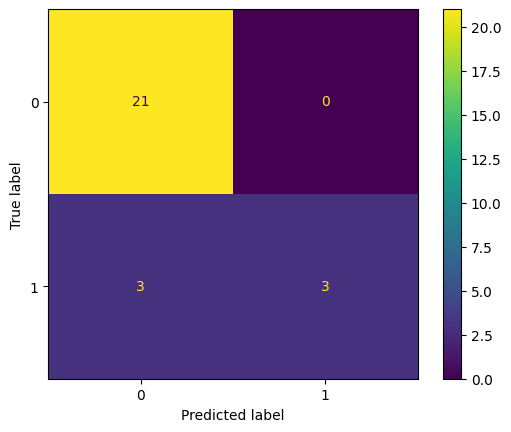

In [15]:
measurements = measure_method_by_class(
    output_fp="./ScoredBaseline-1.csv",
    target_threshold=TARGET_THRESHOLD,
    verbose=False
)

print(f"Accuracy: {measurements['accuracy'] * 100:.2f}%")
cm = ConfusionMatrixDisplay(confusion_matrix=measurements['confusion_matrix'])
cm.plot()
plt.show()